# Maximum Entropy Approximation - mRNA

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import glob
import pickle
import dill
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd
import mpmath
# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_mRNA/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$

---

# The MaxEnt approximation.

Given the difficulty at solving chemical master equations (CME) there is an extensive repertoire of approximate methods to tackle the problem of solving these equations. A particularly interesting method uses the so-called moment-expansion and maximum entropy approach to approximate distributions given knowledge of some of the moments of the distribution.

In particular given a distribution $P_X(x)$, the $n^{\text{th}}$ moment of the distribution for a discrete set of possible values of $x$ is given by
$$
\avg{x^n} \equiv \sum_x x^n P_X(x).
$$

Now assume that we have knowledge of the first $m$ moments. The question is: can we use this information to build an estimator $P_H(x \mid m)$ of the distribution such that
$$
\lim_{m \rightarrow \infty} P_H(x \mid m) \rightarrow P_X(x),
$$
i.e. that the more moments we add to our approximation, the more the estimator distribution converges to the real distribution.

For this we use the principle of maximum entropy in which our best guess for this estimator is built on the base of maximizing the Shannon entropy constrained by the limited information that we have. The maximization Shannon's entropy guarantees that we are less committed to information that we do not posses. The Shannon entropy for a single variable discrete distribution is given by
$$
H(x) \equiv - \sum_x P_X(x) \log P_X(x).
$$

Given the knowledge of the first $m$ moments we define the Lagrangian $\mathcal{L}(x)$ to be maximized as
$$
\mathcal{L}(x) \equiv H(x) - \sum_{i=0}^m 
\left[ \lambda_i \left( \avg{x^i} - \sum_x x^i P_X(x) \right) \right],
$$
where $\lambda_i$ is the Lagrange multiplier associated with the $i^{\text{th}}$ moment.

To find the best guess for the estimator distribution we solve the constrained optimization problem. Setting the variational derivative of the Lagrangian with respect to $P_X(X)$ gives
$$
{\delta \mathcal{L} \over \delta P_X(x)} = -\log P_X(X) - 1 - 
\sum_{i=0}^m \lambda_i \avg{x^i}.
$$

Setting this derivative to zero and solving for the distribution (that we now start calling $P_H(x)$, our MaxEnt estimator) gives
$$
P_H(x) = \exp \left(- 1 - \sum_{i=0}^m \lambda_i \avg{x^i}  \right)
={1 \over \mathcal{Z}}  \exp \left( - \sum_{i=1}^m \lambda_i \avg{x^i}  \right),
$$
where $\mathcal{Z}$ is the normalization constant given by 
$$
\mathcal{Z} \equiv \exp\left( 1 + \lambda_0 \right) = 
\sum_x \exp \left( - \sum_{i=1}^m \lambda_i \avg{x^i}  \right)
$$

## Numerically estimating the probability distribution.

Given that we have a theoretical expectation of what the moments of the distribution are, we can use this approximation to generate an estimate for the entire distribution. The only limiting step is to numerically determine the value of the Lagrange multipliers $\lambda_i$.

Instead of directly estimating the distribution we will use the `maxentropy` package in Python to perform the fit.

In the following example we will fit the classic example of an unfair die with a mean value of $\avg{x} = 4.5$ as done in [this notebook](https://github.com/PythonCharmers/maxentropy/blob/master/notebooks/Loaded%20die%20example%20-%20skmaxent.ipynb).

In [2]:
# Fit a model p(x) for dice probabilities (x=1,...,6) with the
# single constraint E(X) = 4.5
def first_moment_die(x):
    return np.array(x)

# Put the constraint functions into an array
features = [first_moment_die]
# Write down the constraints (in this case mean of 4.5)
k = np.array([4.5])

# Define the sample space of the die (from 1 to 6)
samplespace = list(range(1, 7))

# Define the minimum entropy 
model = MinDivergenceModel(features, samplespace)

# Change the dimensionality of the array
X = np.atleast_2d(k)
# Fit the model
model.fit(X)

MinDivergenceModel(algorithm='CG',
          features=[<function first_moment_die at 0x1a13f71620>],
          matrix_format='csr_matrix', prior_log_probs=None,
          samplespace=[1, 2, 3, 4, 5, 6], vectorized=True, verbose=0)

Let's look at the resulting distribution

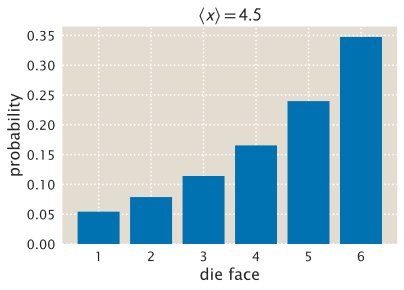

In [3]:
plt.bar(samplespace, model.probdist())
plt.xlabel('die face')
plt.ylabel('probability')
_ = plt.title(r'$\left\langle x \right\rangle = 4.5$')
plt.savefig(figdir + 'biased_die_dist.png', bbox_inches='tight')

Just for curiosity let's see how long it takes to perform this simple fit for the algorithm.

In [12]:
# Fit the model
%timeit model.fit(X)

335 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Import `lambdify` functions using `dill`.

When the analytical results were derived we generated `lambdify` functions to explore these results numerically and export them into a file using the `dill` library. Let's now import these functions into this notebook to make use of them. 

In [4]:
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm)
with open(tmpdir + 'two_state_mRNA_lambdify.dill', 'rb') as file:
    first_unreg_m = dill.load(file)
    second_unreg_m = dill.load(file)
    third_unreg_m = dill.load(file)
    
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm)
with open(tmpdir + 'three_state_mRNA_lambdify.dill', 'rb') as file:
    first_reg_m = dill.load(file)
    second_reg_m = dill.load(file)
    third_reg_m = dill.load(file)

# Two-state unregulated promoter
---

As an exercise to test the performance of this approximation let's fit the Maximum entropy model to the two-state unregulated promoter model. For this we have previously determined the model parameters from experimental data, and there is a closed-form solution for the CME, given the chance to compare the performance of this algorithm.

Let's first define the three functions needed to implement the first three moment constraints.

In [5]:
def first(x):
    return np.array(x)

def second(x):
    return np.array(x)**2

def third(x):
    return np.array(x)**3

Now let's define the parameters for the *lacUV5* unregulated promoter.

In [9]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

We can now use the `maxnetropy` package to fit the maximum entropy model.
Let's do it systematically incrementing the number of moments used for the approximation.

In [10]:
# Put the constraint functions into an array
features = [first, second, third]
# Write down the constraints
m1, m2, m3 = first_unreg_m(*par_UV5.values()), \
             second_unreg_m(*par_UV5.values()),\
             third_unreg_m(*par_UV5.values())

constraints = np.array([m1, m2, m3])


# Define array to save probability dist
maxEnt_prob = np.zeros([len(constraints), 60])
# Loop through number of constraints
for i, c in enumerate(constraints):
    # Define constraints for this iteration
    const = constraints[0:(i + 1)]
    feat = features[0:(i + 1)]
    
    # Select the sample space size given the number of constraints
    # This is due to numerical instability for the 3rd moment
    if i < 2:
        samplespace = list(range(0, 60))
    else:
        samplespace = list(range(0, 1000))

    # Define the minimum entropy 
    model = MinDivergenceModel(feat, samplespace)
    # Change the dimensionality of the array
    X = np.reshape(const, (1, -1))
    # Fit the model
    model.fit(X)
    # Save distribution
    maxEnt_prob[i, :] = model.probdist()[0:60]

Let's plot the different approximations

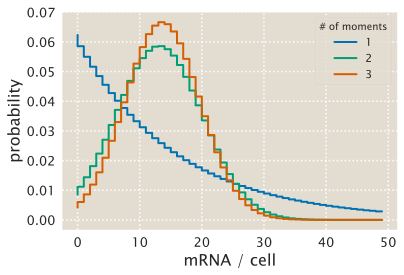

In [11]:
for i, k in enumerate(constraints):
    plt.plot(samplespace[0:50], maxEnt_prob[i, 0:50], 
            label=str(i + 1), drawstyle='steps')
    
plt.legend(title='# of moments')
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.savefig(figdir + 'UV5_MaxEnt_PMF.png', bbox_inches='tight')

### Comparison with experimental data.

Let's now import the experimental data in order to compare the performance of these approximations.

In [12]:
df = pd.read_csv('../../data/mRNA_FISH/Jones_Brewster_2014.csv', index_col=0)
df = df[df.experiment != 'control']
df = df[df.experiment != 'Control']
df = df[df.experiment != 'Ctrl']
df.head()

,area_cells,date,experiment,spots_totals
0,321,20110920,5DL10,0
1,407,20110920,5DL10,4
2,337,20110920,5DL10,3
3,343,20110920,5DL10,2
4,320,20110920,5DL10,0


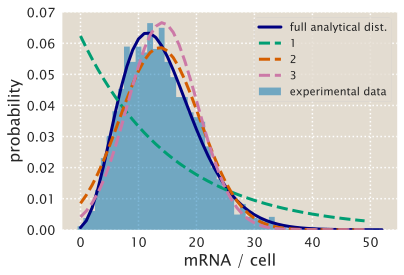

In [13]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())

logp_mRNA = chann_cap.log_p_m_unreg(bins, **par_UV5)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.5, label='experimental data', align='left')
plt.plot(bins, np.exp(logp_mRNA), label='full analytical dist.',
         color='navy', lw=3, linestyle='-')

for i, k in enumerate(constraints):
    plt.plot(samplespace[0:50], maxEnt_prob[i, 0:50], 
            label=str(i + 1), lw=3, linestyle='--')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()
plt.savefig(figdir + 'UV5_data_MaxEnt_PMF.png', bbox_inches='tight')

It is probably easier to compare it using a CDF plot.

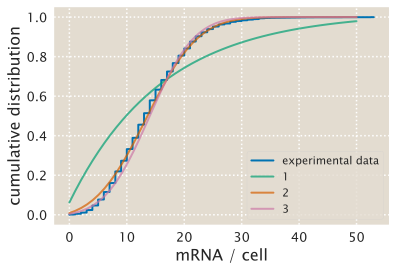

In [14]:
# Compute the empirical CDF
x, y = chann_cap.ecdf(dfUV5.spots_totals.values)
# Plot experimental data
plt.plot(x, y, label='experimental data')

# Loop through moments
for i, k in enumerate(constraints):
    # Compute the theoretical CDF
    cdf = np.cumsum(maxEnt_prob[i, :])
    plt.plot(np.linspace(0, 50), cdf[0:50], 
             ls='-', label=str(i + 1), alpha=0.7)

plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend()
plt.savefig(figdir + 'UV5_data_MaxEnt_CDF.png', bbox_inches='tight')

The second and third moment approximation look pretty decent!
That is encouraging. Now we can try to approximate the three-state promoter distribution including the repressor copy number and binding energy, as well as the inducer concentration as extra inputs.

# Three-state regulated promoter.
---

## Integrating the number of repressors into the picture

The way that the repressor copy number enters the kinetic scheme is by assuming that the $\kron$ rate is a diffusion limited rate of the form
$$
\kron = k_o \left[ R \right].
$$
The constant $k_o$ was indirectly inferred by the Sunney Xie lab and quoted by Jones and Brewster as $k_o = 2.7 \times 10^{-3} (\text{s nM})^{-1}$.

The value of $\kroff$ is then constrained by the value of the binding energy as inferred using equilibrium statistical mechanics. For the stat. mech. framework we have that the fold-change in gene expression is given by
$$
\foldchange = \frac{1}{1 + \frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}},
$$
where $R$ is the absolute copy number of repressors per cell, $N_{NS}$ is the number of non-specific binding sites for the repressors (in our case the entire *E. coli genome* $4.6 \times 10^6$), $\beta$ is the inverse temperature times the Boltzmann constant and $\Delta \epsilon_r$ is the binding energy of the repressor to the operator binding site.

In the case of the three-state promoter the fold-change is given by
$$
\foldchange = {1 \over 1 + {\kron \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}
            = {1 \over 1 + {k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}.
$$

Given that these two equation have the same functional form we can conclude that
$$
\frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r} =
{k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right).
$$
If we solve for $\kroff$ and convert the absolute number or repressors $R$ into a concentration $[R]$ we find that
$$
\kroff = 1.66 \cdot k_0 \cdot N_{NS} e^{\beta \Delta \epsilon_r}
          \left( {\kpoff \over \kpoff + \kpon} \right).
$$

Given this result let's define a function that computes $\kroff$ as a function of the binding energies and the RNAP rates.

In [15]:
def kr_off_fun(eRA, k0, kp_on, kp_off, Nns=4.6E6):
    '''
    Returns the off rate of the repressor as a function of the stat. mech. 
    binding energy and the RNAP on and off rates.
    Parameters
    ----------
    eRA : float.
        Repressor binding energies [kbT]
    k0 : float.
        Diffusion limited constant [s**-1 nM**-1]
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    Returns
    -------
    Repressor off rate
    '''
    return 1.66 * k0 * Nns * np.exp(eRA) * kp_off / (kp_off + kp_on)

Let's now define a function that computes the first three moments of the mRNA distribution as a function of the repressor copy number, repressor-DNA binding energy as well as the inducer concentration.

In [16]:
def moment_reg_m(moment, C, rep, eRA, 
                 k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the MaxEnt distribution approximation as a function  of all the 
    parameters that go into the chemical master equation.
    
    Parameters
    ----------
    moment : string.
        Moment to be computed. Options: 'first', 'second', 'third'.
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    mRNA copy number moment
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    # Compute the repressor off-rate based on the on-rate and the binding energy
    kr_off = kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    if moment == 'first':
        return first_reg_m(kr_on, kr_off, kp_on, kp_off, rm, gm)
    elif moment == 'second':
        return second_reg_m(kr_on, kr_off, kp_on, kp_off, rm, gm)
    elif moment == 'third':
        return third_reg_m(kr_on, kr_off, kp_on, kp_off, rm, gm)
    else:
        print('please specify first, second or third moment.')

We now define a function that takes all these parameters, along with the necessary elements (sample space, constraints, functions to compute moments) and returns the maximum entropy distribution.

In [17]:
def maxent_reg_m(constraint_dict, samplespace, C, rep, eRA,
                 k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5, 
                 algorithm='Powell', disp=False):
    '''
    Computes the mean mRNA copy number  as a function  of all the 
    parameters that go into the chemical master equation.
    
    Parameters
    ----------
    constraint_dict : dictionary.
        Dictionary containing the functions to compute the constraints.
        The name of the entries should be the same as the name of the moments,
        for example constraint_dict = {'first' : first}.
    samplespace : array-like.
        Bins to be evaluated in the maximum entropy approach.
    C : array-like.
        Concentrations at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1] 
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
    algorithm : str.
        Algorithm to be used for the parameter optimization. See
        maxentropy.BaseModel help for a list of the available algorithms.
    disp : bool.
        Boolean indicating if the function should display the concentration
        which is computing at the moment
        
    Returns
    -------
    max_ent_dist : array. shape = len(C) x len(samplespace)
        Maximum Entropy probability distribution of mRNA for each concentration
        in C
    '''
    # Initialize matrix to save distributions
    max_ent_dist = np.zeros([len(C), len(samplespace)])
    # Loop through concentrations
    for j, c in enumerate(C):
        if disp:
            print(c)
        # Initialize list to save constraints and moments
        const_fn = []
        const_name = []
        # Extract each constraint function and element into lists
        for key, val in constraint_dict.items():
            const_name.append(key)
            const_fn.append(val)

        # Initialize array to save moment values
        moments = np.zeros(len(const_name))
        # Compute the value of the moments given the constraints
        for i, moment in enumerate(const_name): 
            moments[i] = moment_reg_m(moment, c, rep, eRA, 
                                      k0, kp_on, kp_off, rm, gm,
                                      Nns, ka, ki, epsilon)

        # Define the minimum entropy moel
        model = MinDivergenceModel(const_fn, samplespace, algorithm=algorithm)
        # Change the dimensionality of the moment array
        X = np.reshape(moments, (1, -1))
        # Fit the model
        model.fit(X)
        max_ent_dist[j, :] = model.probdist()
    
    # Return probability distribution
    return max_ent_dist

Let's now try to test the function.

First let's define a dictionary containing all of the necessar parameters for a regulated lacUV5 promoter

In [18]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

Now let's define the necessary variables to compute the MaxEnt distributions for different IPTG concentrations.

In [20]:
# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second, 'third':third}

# Define concentrations to test
IPTG = [0, 1, 10, 50, 100, 1000] #µM

# Copy parameters and add repressor copy number and binding energy
par = par_UV5_reg.copy()
par['eRA'] = -13.9 #kBT
par['rep'] = 260 #repressors / cell

# Define the sample space
samplespace = np.arange(100)

In [21]:
dist_maxent_reg = maxent_reg_m(constraint_dict, samplespace, IPTG, disp=True,
                               algorithm='Powell',
                               **par)

0
1
10
50
100
1000


Let's plot both the PMF and CDF together.

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


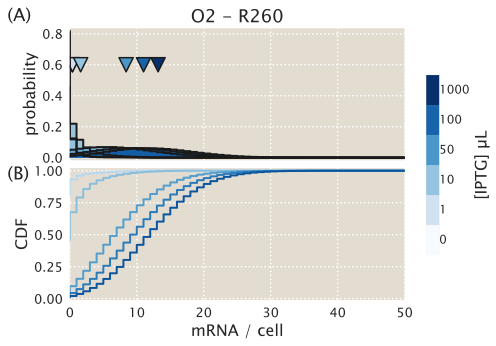

In [22]:
chann_cap.pmf_cdf_plot(samplespace, dist_maxent_reg, IPTG, color_palette='Blues',
             mean_mark=True, marker_height=0.6,
             color_bar=True, cbar_label='[IPTG] µL',
             title='O2 - R260', xlabel='mRNA / cell', xlim=[0,50])

plt.savefig(figdir + 'maxEnt_dist_mRNA_O2_R260.pdf', bbox_inches='tight')

It seems that the function is working! And now we can generate an input-output matrix $P(m \mid C)$ from which to compute the channel capacity using the Blahut-Arimoto algorithm.

# Computing the channel capacity

Having this input-output function let's use the Blahut-Arimoto algorithm function to compute the channel capacity.

First let's test it with the input-output matrix we generated for the example.

In [23]:
c, pc, loop_count = chann_cap.channel_capacity(dist_maxent_reg[:, :80])

print('The channel-capacity is {:.2f} bits'.format(c))

The channel-capacity is 0.84 bits


Let's now systematically build the input-output function for different repressor copy numbers and operators

In [30]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# Define constraint dictionary containing the moments
constraint_dict = {'first':first, 'second':second, 'third':third}

# Define the sample space
samplespace = np.arange(100)
truncation = 80 # number of mRNA where to truncate the matrix

# Define experimental concentrations in µM
c = [0, 0.1, 1, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 1000] # µM

# Define repressor copy numebers
repressors = np.logspace(0, 3, 50)
repressors = np.unique(repressors.round(0))

# Define operators and energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = [-15.3, -13.9, -9.7, -17]
op_dict = dict(zip(operators, energies))
op_dict

{'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

In [31]:
compute_channcap = False
if compute_channcap:
    # initialize data frame to save channel capacity computation
    df_channcap = pd.DataFrame(columns=['operator', 'repressor', 'channcap'])
    # loop through operators
    for op in operators:
        print(op)
        # Define function to compute in parallel the channel capacity
        def cc_parallel(r):
            par = par_UV5_reg.copy()
            par['eRA'] = op_dict[op] #kBT
            par['rep'] = r #repressors / cell
            # Build transition matrix
            QmC = maxent_reg_m(constraint_dict, samplespace, c,
                               **par)
            # Truncate matrix and re-normalize it
            QmC_sum = QmC[:, :truncation].sum(axis=1)
            QmC = np.divide(QmC[:, :truncation].T, QmC_sum).T
            # Compute the channel capacity with the Blahut-Arimoto algorithm
            cc = chann_cap.channel_capacity(QmC, epsilon=1E-3)[0]
            return cc
            # generate a series with the relevant data
        # Run the function in parallel
        ccaps = Parallel(n_jobs=6)(delayed(cc_parallel)(r) for r in repressors)
        # Convert to tidy data frame
        ccaps = pd.DataFrame(ccaps, columns=['channcap'])
        ccaps.loc[:, 'operator'] = pd.Series([op] * len(ccaps))
        ccaps.loc[:, 'repressor'] = pd.Series(repressors)

        df_channcap = pd.concat([df_channcap, ccaps], axis=0)
    df_channcap.to_csv('../../data/csv_maxEnt_dist/chann_cap_maxEnt_mRNA.csv',
                       index=False)

Having compute it let's make the repressor vs. channel capacity plot!

In [32]:
df_channcap = pd.read_csv(\
              '../../data/csv_maxEnt_dist/chann_cap_maxEnt_mRNA.csv',
                         header=0, index_col=None)
print(df_channcap.operator.unique())
df_channcap.head()

['O1' 'O2' 'O3' 'Oid']


,channcap,operator,repressor
0,0.117706,O1,1.0
1,0.241824,O1,2.0
2,0.335095,O1,3.0
3,0.405576,O1,4.0
4,0.460070,O1,5.0


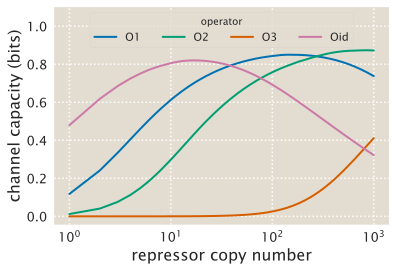

In [45]:
df_group = df_channcap.groupby('operator')

fig, ax = plt.subplots(1, 1)
for group, data in df_group:
    ax.plot(data.repressor, data.channcap, label=group)

ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.set_ylim(top=1.1)
ax.legend(loc='upper center', title='operator', ncol=4)
plt.savefig(figdir + 'repressor_vs_channcap_mRNA.pdf')